In [2]:
#from aiidalab_widgets_base import OptimadeQueryWidget
from aiidalab_widgets_base import StructureBrowserWidget
from aiidalab_widgets_base import StructureManagerWidget
from aiidalab_widgets_base import StructureUploadWidget
from aiidalab_widgets_base import SmilesWidget

# Create the application steps
structure_manager_widget = StructureManagerWidget(
    importers=[
        StructureUploadWidget(title="From computer"),
        SmilesWidget(title='SMILES'),
        StructureBrowserWidget(title="AiiDA database"),
    ],
    node_class='StructureData',
)


display(structure_manager_widget)

StructureManagerWidget(children=(Tab(children=(StructureUploadWidget(children=(FileUpload(value={}, descriptio…

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
DrawingOptions.bondLineWidth=1.8

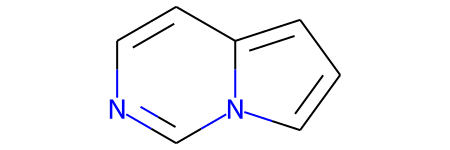

In [4]:
template = Chem.MolFromSmiles('c1nccc2n1ccc2')
#AllChem.Compute2DCoords(template)
template

In [5]:
Chem.Draw.IPythonConsole.InstallIPythonRenderer()

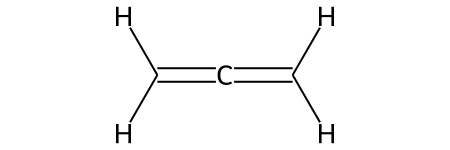

In [6]:
mol = Chem.MolFromSmiles('C=C=C')
mol = AllChem.AddHs(mol)
DrawingOptions.includeAtomNumbers=True
mol

In [7]:
import ipywidgets as widgets

In [8]:
w = widgets.IntSlider()
display(w)

IntSlider(value=0)

In [9]:
display(w)

IntSlider(value=0)

In [10]:
w.close()

In [40]:
a = widgets.FloatText()
b = widgets.FloatSlider()
display(a,b)

mylink = widgets.jslink((a, 'value'), (b, 'value'))


FloatText(value=0.0)

FloatSlider(value=0.0)

In [11]:
text = widgets.Text(
    value='',
    placeholder='SMILES input',
    description='String:',
    disabled=False
)
output = widgets.Output()

display(text, output)

def rdkit_2d_struct(smiles):
    m = Chem.MolFromSmiles(smiles)
    return m

def on_text_change(change):
    smiles = change['new']
    try:
        m = rdkit_2d_struct(smiles)
        with output:
            print(m)
    except:
        pass

text.observe(on_text_change, names='value')

Text(value='', description='String:', placeholder='SMILES input')

Output()

## ORCA SUBMISSION TEST



In [1]:
%aiida

Loaded AiiDA DB environment - profile name: default.

In [5]:
code = load_code('orca@localhost')
builder = code.get_builder()

In [10]:
params = {
    'charge': 0,
    'multiplicity': 1,
    'input_blocks': {
        'scf': {'convergence': 'tight'},
        'pal': {'nproc': 1},
    },
    'input_keywords': ['PBE', 'def2-svp','Opt'],
    'extra_input_keywords': []
}
builder.parameters = Dict(dict=params)

In [11]:
struct = load_node(pk=2)
builder.structure = struct

In [12]:
builder.metadata.options.withmpi = False
builder.metadata.options.resources = {
    'tot_num_mpiprocs': 1,
}
builder.metadata.description = "ORCA optimization"

In [14]:
from aiida.engine import submit
submit(builder)

<CalcJobNode: uuid: 1232d0ed-5f93-4efe-959f-2eadab6a349e (pk: 5) (aiida_orca.calculations.orca_main.OrcaCalculation)>

In [17]:
from aiidalab_widgets_base.viewers import StructureDataViewer

# Spectrum testing

In [12]:
from aiidalab_ispg.spectrum import Spectrum

In [13]:
transition1 = {
    'energy': 1, # Excited energy in eV
    'osc_strength': '0.016510951'
}
transition2 = {
    'energy': 2.0, # Excited energy in eV
    'osc_strength': '0.0'
}
transitions = [transition1, transition2]
nsample = 1
spec = Spectrum(transitions, nsample)
x, y = spec.get_lorentzian_spectrum(0.3, 'ev', 'cross_section')

In [24]:
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, push_notebook
import ipywidgets as ipw
output_notebook()

Loading BokehJS ...

In [33]:
spec = Spectrum(transitions, nsample)

# TODO: Figure out how to use with ipywidgets
# https://github.com/bokeh/bokeh/issues/7023

# Initial spectrum
x, y = spec.get_lorentzian_spectrum(0.5, 'ev', 'cross_section')    
f = figure(title="Spectrum test",  x_axis_label='E / eV',   y_axis_label='I / cm^-2 * molecule ^ -1')
line = f.line(x, y, line_width=2)

def plot_spectrum(width):
    nsample = 1
    x, y = spec.get_lorentzian_spectrum(width, 'ev', 'cross_section')
    line.data_source.data['x'] = x
    line.data_source.data['y'] = y
    push_notebook()

handle = show(f, notebook_handle=True)
i = ipw.interact(plot_spectrum, width=(0.05, 1.0, 0.05))

interactive(children=(FloatSlider(value=0.5, description='width', max=1.0, min=0.05, step=0.05), Output()), _d…